# Examples for three body dynamics using the CR3BP

Yuri Shimane

This notebook demonstrates some functionialities of polaris in the circular restircted three body problem (CR3BP). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')   # path to polaris module

import polaris.SolarSystemConstants as sscs
import polaris.Keplerian as kepl
import polaris.Propagator as prop
import polaris.R3BP as r3bp

### Define parameters of the Earth-Moon system

Using the R3BP module within polaris, the Earth-Moon CR3BP system parameters are defined. This is done by calling the function ```r3bp.get_cr3bp_param()``` with NAIF body ID's of the Earth and the Moon. 

For NAID body ID's, refer to : https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/req/naif_ids.html

The obtained parameters in the object ```param_earth_moon``` include
```python
    param_earth_moon.mu       # CR3BP mass parameter
    param_earth_moon.lstar    # canonical length-scale, km
    param_earth_moon.tstar    # canonical time-scale, sec
    param_earth_moon.mstar    # canonical value of GM, km**3/sec**2
    param_earth_moon.m2_soi   # sphere-of-influence of second body in a two-body sense
```

In [3]:
param_earth_moon = r3bp.get_cr3bp_param('399','301')   # NAIF ID's '399': Earth, '301': Moon
param_earth_moon.mu

0.012150584269940354

### Construct initial guess of halo with 3rd order approximation

In [14]:
haloinit = r3bp.get_halo_approx(mu=param_earth_moon.mu, lp=1, lstar=param_earth_moon.lstar, 
                                az_km=4000, family=1, phase=0.0)

In [15]:
haloinit["period_guess"], haloinit["state_guess"]

(2.7426807265589157,
 array([0.82381383, 0.        , 0.01110192, 0.        , 0.12694808,
        0.        ]))

### Correct initial guess with single-shooting differential correction

In [16]:
p_conv, state_conv, flag_conv = r3bp.ssdc_periodic_xzplane(param_earth_moon, haloinit["state_guess"], 
                                                           haloinit["period_guess"], fix="z", message=False)

In [24]:
p_conv

2.7438370345592453

### Propagation in CR3BP

Here, we consider a halo orbit of a known initial state and period. This is propagated using the function ```prop.propagate_cr3bp()```. 

In [25]:
prop0 = prop.propagate_cr3bp(param_earth_moon, state_conv, p_conv)

In [33]:
prop0.statef[3:6]

array([ 5.43003692e-10,  1.28354748e-01, -2.24281477e-11])

In [32]:
param_earth_moon.mu

0.012150584269940354

### Plot result

<IPython.core.display.Javascript object>


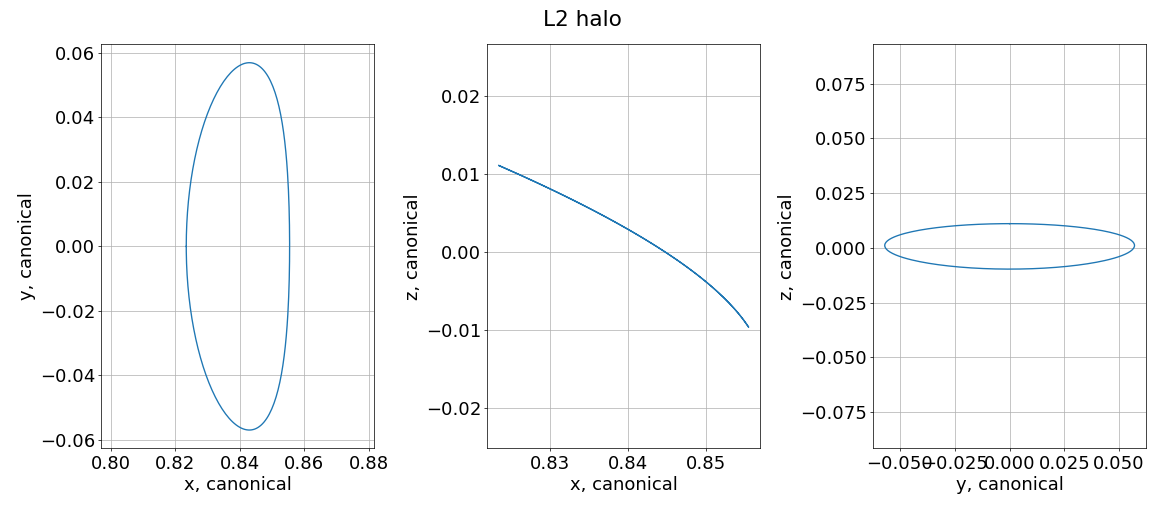

In [19]:
plt.rcParams["font.size"] = 20
fig, axs = plt.subplots(1, 3, figsize=(18, 8))
axs[0].plot(prop0.xs, prop0.ys)
axs[0].set(xlabel='x, canonical', ylabel='y, canonical')
axs[1].plot(prop0.xs, prop0.zs)
axs[1].set(xlabel='x, canonical', ylabel='z, canonical')
axs[2].plot(prop0.ys, prop0.zs)
axs[2].set(xlabel='y, canonical', ylabel='z, canonical')
for idx in range(3):
    axs[idx].grid(True)
    axs[idx].axis("equal")
plt.suptitle('L2 halo')
plt.tight_layout(rect=[0, 0.01, 1, 1.03])
plt.show()

In [20]:
data = [prop0.xs, prop0.ys, prop0.zs]
df = pd.DataFrame(data, index=['xs', 'ys', 'zs']).T
fig = px.line_3d(df, x="xs", y="ys", z="zs")
fig.show()

### Generate manifolds of periodic orbit

Using a periodic motion in the CR3BP, unstable and stable manifolds may be constructed using the eigenvectors of the monodromy matrix. This is obtained with the ```r3bp.get_manifolds()``` function. 

In [21]:
mnfpls, mnfmin = r3bp.get_manifold(param_earth_moon, state_conv, p_conv, tf_manif=10.0,
                                   stable=False, force_solve_ivp=False)

Manifold:   0%|          | 0/50 [00:00<?, ?it/s]

In [22]:
mnfpls.branches[0].propout.times

array([0.00000000e+00, 5.00250125e-03, 1.00050025e-02, ...,
       9.98999500e+00, 9.99499750e+00, 1.00000000e+01])

<IPython.core.display.Javascript object>


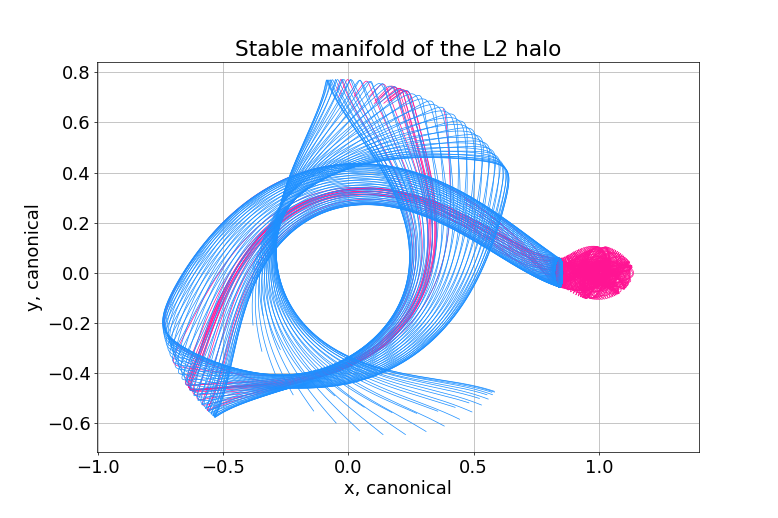

In [23]:
plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(1,1, figsize=(12,8))
for branch in mnfpls.branches:
    ax.plot(branch.propout.xs, branch.propout.ys, linewidth=0.8, c='deeppink')
    
for branch in mnfmin.branches:
    ax.plot(branch.propout.xs, branch.propout.ys, linewidth=0.8, c='dodgerblue')

ax.set(xlabel='x, canonical', ylabel='y, canonical', title='Stable manifold of the L2 halo')
plt.grid(True)
plt.axis("equal")
plt.show()